# Exp 06. 영화리뷰 감성분석

### 1) 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from konlpy.tag import Mecab
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터 로더 구성
- 데이터의 중복 제거
- 특수문자 제거
- `NaN` 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `x_train`, `y_train`, `x_test`, `y_test`, `word_to_index` 리턴

#### 중복 확인

In [2]:
print(f"Train 중복 : {len(train_data)-len(train_data['document'].value_counts())}개")
print(f"Test 중복 : {len(test_data)-len(test_data['document'].value_counts())}개")

Train 중복 : 3818개
Test 중복 : 843개


In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # Train 중복, 특문, 공백, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    train_data['document'].replace(' ', np.nan, inplace=True)
    train_data = train_data.dropna(how = 'any')
    
    # Test 중복, 특문, 공백, 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'].replace(' ', np.nan, inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    # Train 토큰화 및 불용어 처리
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
        
    # Test 토큰화 및 불용어 처리
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

/tmp/ipykernel_2590/545445218.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_2590/545445218.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [4]:
print(f"Train 중복 : {len(train_data)-len(train_data['document'].value_counts())}개")
print(f"Test 중복 : {len(test_data)-len(test_data['document'].value_counts())}개")

Train 중복 : 2502개
Test 중복 : 741개


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '게',
 11: '지',
 12: '있',
 13: '없',
 14: '좋',
 15: '나',
 16: '었',
 17: '만',
 18: '는데',
 19: '너무',
 20: '봤',
 21: '적',
 22: '안',
 23: '정말',
 24: '로',
 25: '것',
 26: '음',
 27: '아',
 28: '네요',
 29: '어',
 30: '재밌',
 31: '지만',
 32: '같',
 33: '진짜',
 34: '에서',
 35: '했',
 36: '기',
 37: '네',
 38: '않',
 39: '점',
 40: '거',
 41: '았',
 42: '수',
 43: '되',
 44: '면',
 45: 'ㅋㅋ',
 46: '인',
 47: '말',
 48: '연기',
 49: '주',
 50: '최고',
 51: '내',
 52: '평점',
 53: '이런',
 54: '던',
 55: '어요',
 56: '할',
 57: '왜',
 58: '겠',
 59: '스토리',
 60: '해',
 61: 'ㅋㅋㅋ',
 62: '습니다',
 63: '듯',
 64: '아니',
 65: '드라마',
 66: '생각',
 67: '더',
 68: '그',
 69: '싶',
 70: '사람',
 71: '때',
 72: '감동',
 73: '배우',
 74: '함',
 75: '본',
 76: '까지',
 77: '뭐',
 78: '알',
 79: '만들',
 80: '내용',
 81: '볼',
 82: '보다',
 83: '감독',
 84: '라',
 85: '재미',
 86: '그냥',
 87: '시간',
 88: '지루',
 89: '중',
 90: '재미있',
 91: '였',
 92: '잼',
 93: '년',
 94: '사랑',
 

In [6]:
# 딕셔너리를 단어 인덱스 리스트 벡터로 변환
# 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 문장을 한 번에 단어 인덱스 리스트 벡터로 encode
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터를 decode
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터를 한 번에 decode
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
# decode 확인
print(get_decoded_sentence(X_train[100], index_to_word))
print('라벨: ', y_train[100])

<PAD> 작화 <PAD> 하나 카 나 연기 해 줘서 더 대박 였 다
라벨:  1


### 3) 데이터 분석 및 가공

In [8]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

문장길이 평균 :  13.726947212048254
문장길이 최대 :  83
문장길이 표준편차 :  11.468277338367118
pad_sequences maxlen :  36
전체 문장의 93.39599928284198%가 maxlen 설정값 이내에 포함됩니다. 


#### padding

In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape, X_test.shape)

(146094, 36) (49121, 36)


In [10]:
X_val = X_train[:30000]   
y_val = y_train[:30000]

partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape, partial_y_train.shape)

(116094, 36) (116094,)


In [11]:
vocab_size = 10000
word_vector_dim = 200

### 4) 모델 설계

### 단방향 LSTM

In [12]:
lstm_model = keras.Sequential(name='LSTM')
lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(keras.layers.LSTM(36))
lstm_model.add(keras.layers.Dense(36, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 36)                34128     
_________________________________________________________________
dense (Dense)                (None, 36)                1332      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 37        
Total params: 2,035,497
Trainable params: 2,035,497
Non-trainable params: 0
_________________________________________________________________


### 1D-CNN

In [13]:
cnn_model = keras.Sequential(name='1D-CNN')
cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(keras.layers.Conv1D(36, 4, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(5))
cnn_model.add(keras.layers.Conv1D(36, 4, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(9, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

cnn_model.summary()

Model: "1D-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 36)          28836     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 36)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 36)          5220      
_________________________________________________________________
global_max_pooling1d (Global (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 333       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10   

### 양방향 LSTM

In [14]:
bilstm_model = keras.Sequential(name='Bidirectional_LSTM')
bilstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
bilstm_model.add(keras.layers.Bidirectional(keras.layers.LSTM(200)))
bilstm_model.add(keras.layers.Dense(200, activation='relu'))
bilstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

bilstm_model.summary()

Model: "Bidirectional_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               641600    
_________________________________________________________________
dense_4 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 2,722,001
Trainable params: 2,722,001
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 학습

### 단방향 LSTM

In [15]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

lstm_history = lstm_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 5s 9ms/step - loss: 0.4730 - accuracy: 0.7590 - val_loss: 0.3643 - val_accuracy: 0.8385
Epoch 2/5
227/227 [==============================] - 2s 7ms/step - loss: 0.3403 - accuracy: 0.8522 - val_loss: 0.3538 - val_accuracy: 0.8422
Epoch 3/5
227/227 [==============================] - 2s 7ms/step - loss: 0.3145 - accuracy: 0.8619 - val_loss: 0.3553 - val_accuracy: 0.8433
Epoch 4/5
227/227 [==============================] - 2s 7ms/step - loss: 0.2924 - accuracy: 0.8706 - val_loss: 0.3648 - val_accuracy: 0.8436
Epoch 5/5
227/227 [==============================] - 2s 7ms/step - loss: 0.2677 - accuracy: 0.8809 - val_loss: 0.3787 - val_accuracy: 0.8440


In [16]:
lstm_history_dict = lstm_history.history

<Figure size 432x288 with 0 Axes>

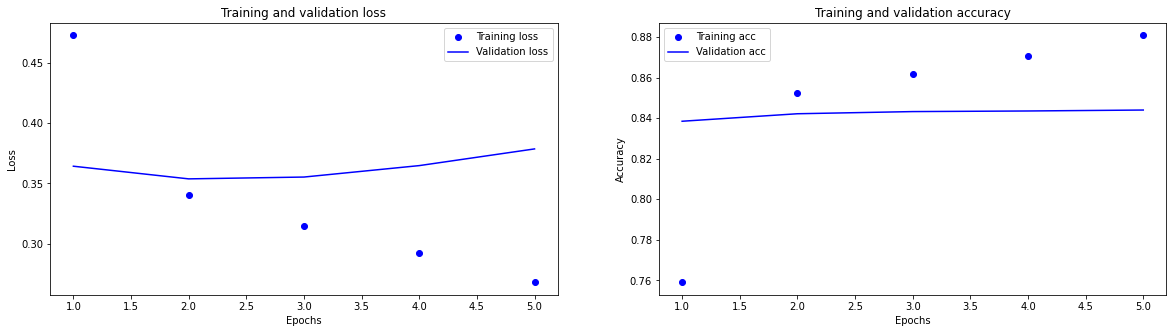

In [17]:
acc = lstm_history_dict['accuracy']
val_acc = lstm_history_dict['val_accuracy']
loss = lstm_history_dict['loss']
val_loss = lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1D-CNN

In [18]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

cnn_history = cnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 4s 9ms/step - loss: 0.4542 - accuracy: 0.7797 - val_loss: 0.3505 - val_accuracy: 0.8450
Epoch 2/5
227/227 [==============================] - 1s 7ms/step - loss: 0.3124 - accuracy: 0.8665 - val_loss: 0.3442 - val_accuracy: 0.8486
Epoch 3/5
227/227 [==============================] - 1s 7ms/step - loss: 0.2513 - accuracy: 0.8976 - val_loss: 0.3574 - val_accuracy: 0.8495
Epoch 4/5
227/227 [==============================] - 1s 7ms/step - loss: 0.1870 - accuracy: 0.9285 - val_loss: 0.3931 - val_accuracy: 0.8439
Epoch 5/5
227/227 [==============================] - 1s 6ms/step - loss: 0.1263 - accuracy: 0.9547 - val_loss: 0.4665 - val_accuracy: 0.8377


In [19]:
cnn_history_dict = cnn_history.history

<Figure size 432x288 with 0 Axes>

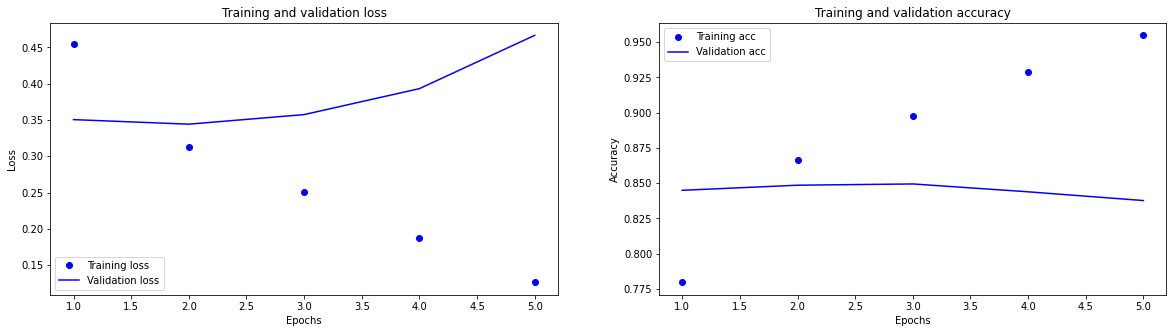

In [20]:
acc = cnn_history_dict['accuracy']
val_acc = cnn_history_dict['val_accuracy']
loss = cnn_history_dict['loss']
val_loss = cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 양방향 LSTM

In [21]:
bilstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

bilstm_history = bilstm_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 12s 41ms/step - loss: 0.4177 - accuracy: 0.8018 - val_loss: 0.3529 - val_accuracy: 0.8432
Epoch 2/5
227/227 [==============================] - 9s 38ms/step - loss: 0.3276 - accuracy: 0.8572 - val_loss: 0.3435 - val_accuracy: 0.8468
Epoch 3/5
227/227 [==============================] - 9s 38ms/step - loss: 0.2884 - accuracy: 0.8745 - val_loss: 0.3520 - val_accuracy: 0.8490
Epoch 4/5
227/227 [==============================] - 9s 38ms/step - loss: 0.2546 - accuracy: 0.8905 - val_loss: 0.3718 - val_accuracy: 0.8479
Epoch 5/5
227/227 [==============================] - 9s 39ms/step - loss: 0.2248 - accuracy: 0.9035 - val_loss: 0.3929 - val_accuracy: 0.8452


In [22]:
bilstm_history_dict = bilstm_history.history

<Figure size 432x288 with 0 Axes>

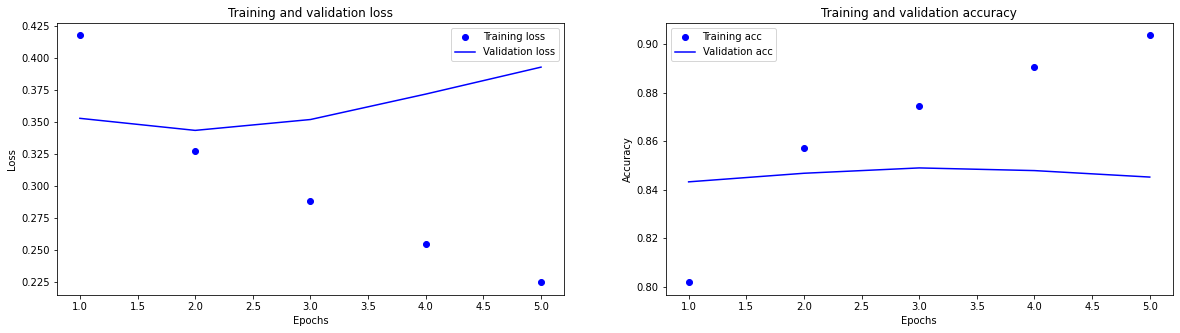

In [23]:
acc = bilstm_history_dict['accuracy']
val_acc = bilstm_history_dict['val_accuracy']
loss = bilstm_history_dict['loss']
val_loss = bilstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 6) Embedding 분석

In [24]:
embedding_layer = bilstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 200)


In [25]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = bilstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']

In [27]:
word_vectors.similar_by_word("웃음")

[('신기', 0.4689007103443146),
 ('금방', 0.4456191658973694),
 ('모두', 0.4440322518348694),
 ('작년', 0.43701863288879395),
 ('목사', 0.4343363046646118),
 ('이지나', 0.43351730704307556),
 ('배울', 0.4286707043647766),
 ('신분', 0.42394453287124634),
 ('박사', 0.42312318086624146),
 ('팔마', 0.4229409396648407)]

In [28]:
word_vectors.similar_by_word("공포")

[('정서', 0.4520069360733032),
 ('비평', 0.4517022967338562),
 ('창피', 0.4426721930503845),
 ('실력', 0.42177078127861023),
 ('핸드폰', 0.4197794198989868),
 ('빠', 0.41730567812919617),
 ('군상', 0.416486918926239),
 ('표지', 0.41192030906677246),
 ('이순재', 0.40280619263648987),
 ('반갑', 0.4010259509086609)]

### 7) word2vec

### 단방향

In [29]:
from gensim.models import Word2Vec 

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [30]:
word2vec.similar_by_word("짜증")

/tmp/ipykernel_2590/298478903.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("짜증")


[('싫증', 0.7431163787841797),
 ('흠집', 0.590933620929718),
 ('흉내', 0.5880372524261475),
 ('아물', 0.5121865272521973),
 ('울음소리', 0.5063953995704651),
 ('탄로', 0.4944570064544678),
 ('그러', 0.4920297861099243),
 ('내보', 0.48765820264816284),
 ('악취', 0.48633816838264465),
 ('이거', 0.48398834466934204)]

In [31]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2590/903695008.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2590/903695008.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [32]:
from tensorflow.keras.initializers import Constant

word2vec_model = keras.Sequential(name='word2vec')
word2vec_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen,
                                 trainable=True))
word2vec_model.add(keras.layers.LSTM(512))
word2vec_model.add(keras.layers.Dense(8, activation='relu'))
word2vec_model.add(keras.layers.Dense(1, activation='sigmoid'))

word2vec_model.summary()

Model: "word2vec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,464,337
Trainable params: 3,464,337
Non-trainable params: 0
_________________________________________________________________


In [33]:
word2vec_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
batch_size=512

word2vec_history = word2vec_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/5
227/227 - 14s - loss: 0.5957 - accuracy: 0.6521 - val_loss: 0.4317 - val_accuracy: 0.7981
Epoch 2/5
227/227 - 12s - loss: 0.3732 - accuracy: 0.8318 - val_loss: 0.3436 - val_accuracy: 0.8455
Epoch 3/5
227/227 - 12s - loss: 0.3061 - accuracy: 0.8671 - val_loss: 0.3263 - val_accuracy: 0.8553
Epoch 4/5
227/227 - 12s - loss: 0.2718 - accuracy: 0.8844 - val_loss: 0.3203 - val_accuracy: 0.8593
Epoch 5/5
227/227 - 12s - loss: 0.2370 - accuracy: 0.9010 - val_loss: 0.3483 - val_accuracy: 0.8591


In [34]:
word2vec_history_dict = word2vec_history.history

<Figure size 432x288 with 0 Axes>

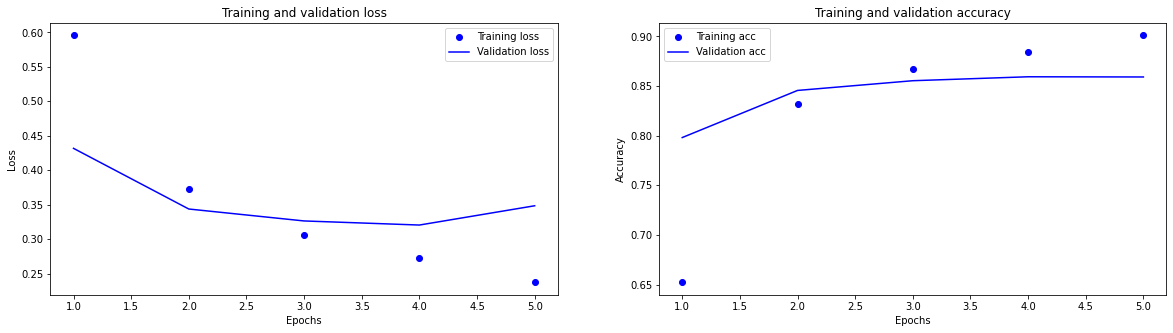

In [35]:
acc = word2vec_history_dict['accuracy']
val_acc = word2vec_history_dict['val_accuracy']
loss = word2vec_history_dict['loss']
val_loss = word2vec_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 양방향

In [36]:
from tensorflow.keras.initializers import Constant

word2vec_bi_model = keras.Sequential(name='word2vec')
word2vec_bi_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen,
                                 trainable=True))
word2vec_bi_model.add(keras.layers.Bidirectional(keras.layers.LSTM(512)))
word2vec_bi_model.add(keras.layers.Dense(8, activation='relu'))
word2vec_bi_model.add(keras.layers.Dense(1, activation='sigmoid'))

word2vec_bi_model.summary()

Model: "word2vec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              2920448   
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 8200      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 4,928,657
Trainable params: 4,928,657
Non-trainable params: 0
_________________________________________________________________


In [37]:
word2vec_bi_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3
batch_size=512

word2vec_bi_history = word2vec_bi_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/3
227/227 - 28s - loss: 0.4794 - accuracy: 0.7629 - val_loss: 0.3825 - val_accuracy: 0.8241
Epoch 2/3
227/227 - 25s - loss: 0.3324 - accuracy: 0.8551 - val_loss: 0.3273 - val_accuracy: 0.8555
Epoch 3/3
227/227 - 25s - loss: 0.2839 - accuracy: 0.8793 - val_loss: 0.3269 - val_accuracy: 0.8548


In [38]:
word2vec_bi_history_dict = word2vec_bi_history.history

<Figure size 432x288 with 0 Axes>

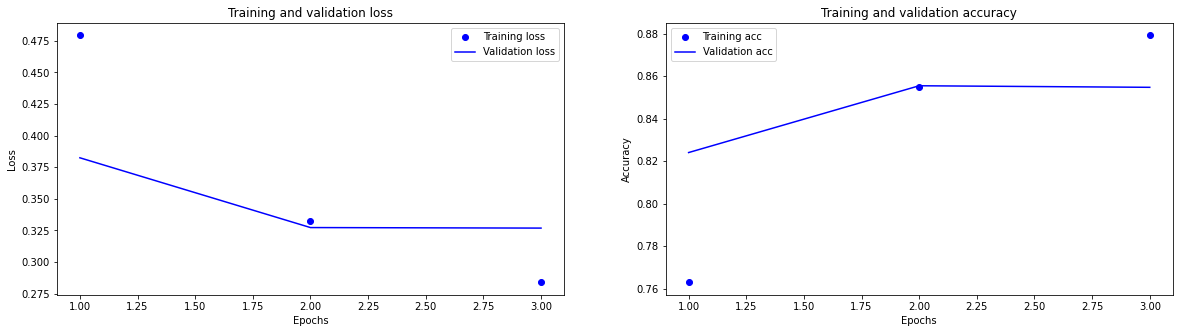

In [39]:
acc = word2vec_bi_history_dict['accuracy']
val_acc = word2vec_bi_history_dict['val_accuracy']
loss = word2vec_bi_history_dict['loss']
val_loss = word2vec_bi_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 단방향

In [40]:
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = word2vec_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [41]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']

In [42]:
word_vectors.similar_by_word("웃음")

[('표정', 0.6622388362884521),
 ('기쁨', 0.6614685654640198),
 ('농담', 0.6552416086196899),
 ('즐거움', 0.6541790962219238),
 ('느낌', 0.6346784830093384),
 ('슬픔', 0.6259869337081909),
 ('추억', 0.6192268133163452),
 ('몸짓', 0.5857930183410645),
 ('매력', 0.5847305059432983),
 ('아름다움', 0.5827777981758118)]

In [43]:
word_vectors.similar_by_word("공포")

[('증오', 0.44194549322128296),
 ('풍자', 0.43900173902511597),
 ('억압', 0.4338993430137634),
 ('두려움', 0.43123000860214233),
 ('혐오', 0.4289472997188568),
 ('부패', 0.4108257293701172),
 ('불안', 0.4105663001537323),
 ('반항', 0.41029852628707886),
 ('탄압', 0.4085312783718109),
 ('범죄', 0.3970280587673187)]

### 양방향

In [44]:
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = word2vec_bi_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [45]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']

In [46]:
word_vectors.similar_by_word("웃음")

[('표정', 0.6702942848205566),
 ('기쁨', 0.6699812412261963),
 ('즐거움', 0.6618049740791321),
 ('농담', 0.6583817005157471),
 ('느낌', 0.6363767385482788),
 ('슬픔', 0.6337906718254089),
 ('추억', 0.625737190246582),
 ('호기심', 0.6004584431648254),
 ('매력', 0.5974612236022949),
 ('몸짓', 0.5954980850219727)]

In [47]:
word_vectors.similar_by_word("공포")

[('억압', 0.44177865982055664),
 ('풍자', 0.4399123191833496),
 ('증오', 0.43748944997787476),
 ('두려움', 0.43235135078430176),
 ('혐오', 0.42626386880874634),
 ('부패', 0.4167444705963135),
 ('반항', 0.4095359742641449),
 ('탄압', 0.40933746099472046),
 ('불안', 0.4089113473892212),
 ('범죄', 0.3986901640892029)]

### 8) 전체 테스트 결과

In [48]:
lstm_result = lstm_model.evaluate(X_test, y_test, verbose=2)
lstm_result

1536/1536 - 3s - loss: 0.3852 - accuracy: 0.8406


[0.3852144479751587, 0.8406180739402771]

In [49]:
cnn_result = cnn_model.evaluate(X_test, y_test, verbose=2)
cnn_model

1536/1536 - 3s - loss: 0.4731 - accuracy: 0.8355


In [50]:
bilstm_result = bilstm_model.evaluate(X_test, y_test, verbose=2)
bilstm_result

1536/1536 - 4s - loss: 0.3969 - accuracy: 0.8402


[0.396860271692276, 0.8401905298233032]

In [51]:
word2vec_result = word2vec_model.evaluate(X_test, y_test, verbose=2)
word2vec_result

1536/1536 - 5s - loss: 0.3569 - accuracy: 0.8565


[0.35693615674972534, 0.8564972281455994]

In [52]:
word2vec_bi_result = word2vec_bi_model.evaluate(X_test, y_test, verbose=2)
word2vec_bi_result

1536/1536 - 8s - loss: 0.3326 - accuracy: 0.8522


[0.3326386511325836, 0.8522017002105713]

### 8) 회고

- 단방향 LSTM, 양방향 LSTM, 1D-CNN 3가지 모델을 기본적으로 사용
- 성능 확인 시 제대로 나오지 않는 것을 확인(연관성 없는 단어 검출)
- word2vec을 이용하여 학습 시 단어 검출이 잘 되는 것을 확인
- 사전학습 모델을 사용하더라도 정확도 향상이 미미한것으로 봐서 데이터셋에 문제가 있을 수 있음